# Random Forest Challenge

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
import time
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

## Read in Data

In [2]:
# Read in data
df = pd.read_csv('spotify.csv')

In [3]:
# Remove first column
df = df.drop('Unnamed: 0',axis=1)

In [4]:
# Preview data
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


## Investigate & Explore Data

In [29]:
# Check for class imbalance

df['target'].value_counts()

1    1020
0     997
Name: target, dtype: int64

In [5]:
# Evaluate if there are any null values in the data set
# The data were exported from spotify's API and there appear to be no NaN values

df.isnull().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
target              0
song_title          0
artist              0
dtype: int64

In [6]:
# Drop object attributes, 'song_title' and 'artist
df = df.drop('song_title',axis=1)
df = df.drop('artist',axis=1)

In [7]:
# Evaluate number of attributes
len(df.columns)

14

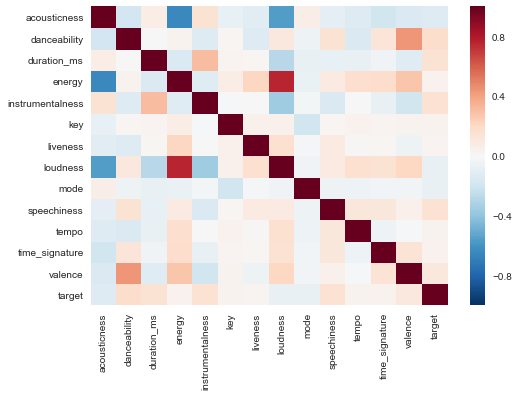

In [8]:
# Evaluate relationship between attributes and target variable
sns.heatmap(df.corr())

## Feature Selection

### Mutual Information

In [9]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Store features and target variable
c
Y = df['target']

# Initialize selector
selector = SelectKBest(mutual_info_classif,k=5)

# Fit selector to data
selector.fit(X, Y)

# Store results
idxs_selected = selector.get_support(indices=True)
result = X[X.columns[[idxs_selected]]]

In [10]:
# Preview results
result.head(3)

,acousticness,danceability,duration_ms,instrumentalness,loudness
0,0.0102,0.833,204600,0.021900,-8.795
1,0.1990,0.743,326933,0.006110,-10.401
2,0.0344,0.838,185707,0.000234,-7.148


### Recursive Feature Elimination 

In [60]:
# Store features and target variable
X = df.drop('target',axis=1)
Y = df['target']

from sklearn.feature_selection import RFE
rfc = ensemble.RandomForestClassifier(n_estimators=10)

names = df.columns

rfe = RFE(rfc, n_features_to_select=13)
rfe.fit(X,Y)

print ("Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))

Features sorted by their rank:
[(1, 'acousticness'), (1, 'danceability'), (1, 'duration_ms'), (1, 'energy'), (1, 'instrumentalness'), (1, 'key'), (1, 'liveness'), (1, 'loudness'), (1, 'mode'), (1, 'speechiness'), (1, 'tempo'), (1, 'time_signature'), (1, 'valence')]


In [12]:
X = df[['loudness','duration_ms','energy','speechiness','instrumentalness']]

## Decision Tree

### Performance on all data

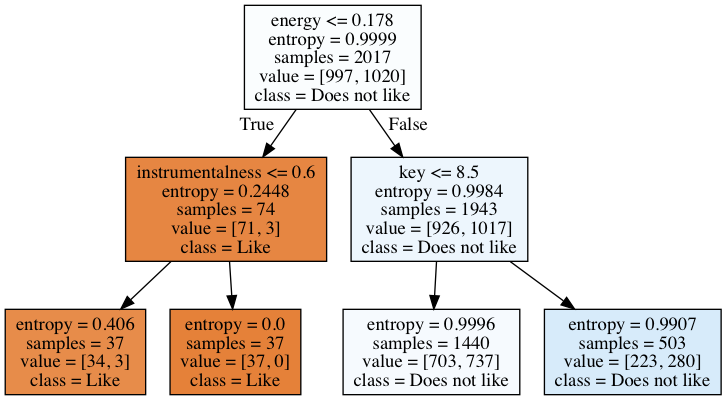

In [90]:
# Store features and target variable
X = df.drop('target',axis=1)
Y = df['target']

# Initialize decision tree
decision_tree = tree.DecisionTreeClassifier(
criterion='entropy',
max_features=1,
max_depth=2,
)

# Fit decision tree to selected features and target variable
decision_tree.fit(X,Y)

# Store data for tree graph 
dot_data = tree.export_graphviz(
decision_tree,out_file=None,
feature_names=X.columns,
class_names=['Like','Does not like'],
filled=True
)

# Graph tree 
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [14]:
# Evaluate run time for 10-fold cross validation

start_time = time.time()

dt_score = cross_val_score(decision_tree,result,Y,cv=10)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.05372786521911621 seconds ---


In [15]:
# Evaluate mean model performance score 
dt_score.mean()

0.61124575144081583

### Performance using top 5 features from recursive feature elimination

Over half of the features were eliminated and runtime was similar -- performance appears to be marginally better. 

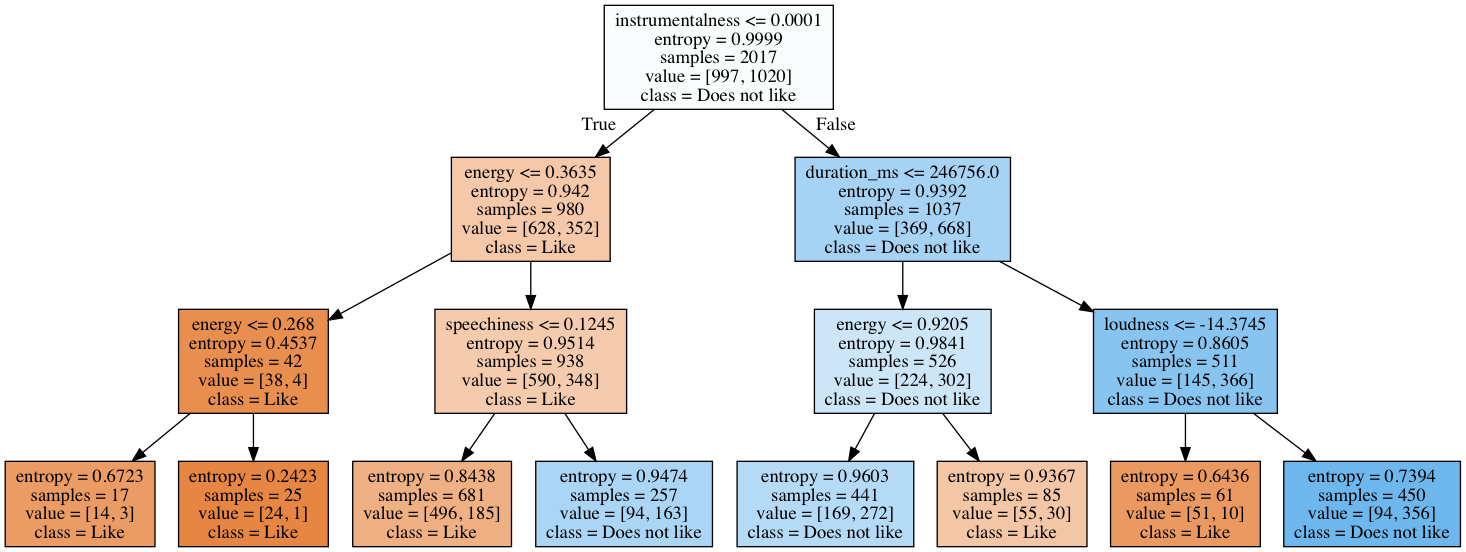

In [34]:
# Store features and target variable
X = df[['loudness','duration_ms','energy','speechiness','instrumentalness']]
Y = df['target']

# Initialize decision tree
decision_tree = tree.DecisionTreeClassifier(
criterion='entropy',
max_features=1,
max_depth=3,
)

# Fit decision tree to selected features and target variable
decision_tree.fit(X,Y)

# Store data for tree graph 
dot_data = tree.export_graphviz(
decision_tree,out_file=None,
feature_names=X.columns,
class_names=['Like','Does not like'],
filled=True
)

# Graph tree 
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [35]:
# Evaluate run time for 10-fold cross validation

start_time = time.time()

dt_score = cross_val_score(decision_tree,result,Y,cv=10)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.04921603202819824 seconds ---


In [36]:
# Evaluate mean model performance score 
dt_score.mean()

0.62568592680163537

## Random Forest

### Performance on all data

In [37]:
# Store features and target variable
X = df.drop('target',axis=1)
Y = df['target']

In [38]:
# Run same cross validation procedure with random forest

rfc = ensemble.RandomForestClassifier(n_estimators=10)

start_time = time.time()

rfc_score = cross_val_score(rfc, X, Y, cv=10)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.45498013496398926 seconds ---


In [39]:
# Evaluate results
np.mean(rfc_score)

0.71938820747746413

### Performance using top 5 features from recursive feature elimination

Even though over half of the features were liminated, performance remains similar to previous model and run time was cut by 37%

In [80]:
# Store features and target variable
X = df[['acousticness','danceability','duration_ms','energy','instrumentalness']]
Y = df['target']

In [81]:
# Run same cross validation procedure with random forest

rfc = ensemble.RandomForestClassifier(n_estimators=10)

start_time = time.time()

rfc_score = cross_val_score(rfc, X, Y, cv=10)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.49795007705688477 seconds ---


In [82]:
# Evaluate results
np.mean(rfc_score)

0.67723757450371891

### Evaluating variance in performance based on # of attributes used

There appear to be diminishing returns as you increase the number of attributes used. 

In [61]:
cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence']

In [70]:
features_num = [1,2,3,4,5,6,7,8,9,10,11,12,13]
accuracy = []

Y = df['target']
rfc = ensemble.RandomForestClassifier(n_estimators=10)

for i in range(1,14):
    X = df[cols[0:i]]
    rfc_score = cross_val_score(rfc, X, Y, cv=10)
    accuracy.append(np.mean(rfc_score))

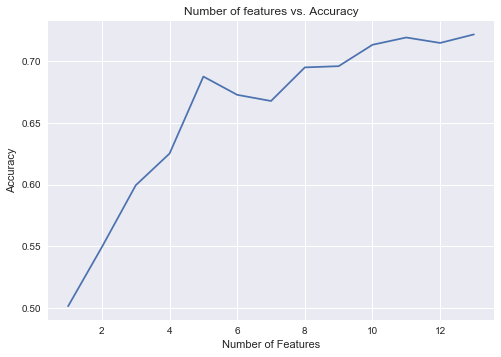

In [73]:
#Evaluate how run time changes with number of estimators

plt.plot(features_num,accuracy)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Number of features vs. Accuracy')

In [89]:
max(accuracy) - min(accuracy)

0.22060735924338704

### Evaluating random forest estimator parameter 

In the below charts, you'll see that run time and estimators have a pretty linear relationship - with one increasing as the other does. However, this doesn't hold true when you evaluate number of estimators vs. performance. After about 30 estimators, your performance hits a wall -- but even then the increase in performance from 10 to 30 estimators is marignal. 

In [25]:
#Store run time and model accuracy for estimators ranging from 10 - 200, intervals of 10

estimators = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
performance = []
duration = []

for i in estimators:
    rfc = ensemble.RandomForestClassifier(n_estimators=i)
    start_time = time.time()
    rfc_score = cross_val_score(rfc, X, Y, cv=10)
    duration.append(time.time() - start_time)
    performance.append(np.mean(rfc_score))   

In [26]:
# Store results in data frame
rf_performance = pd.DataFrame()
rf_performance['estimators_num'] = estimators
rf_performance['accuracy'] = performance
rf_performance['run_time'] = duration

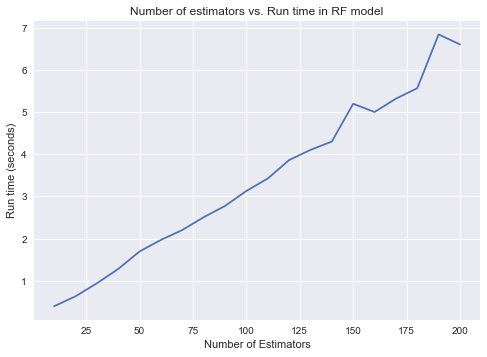

In [27]:
#Evaluate how run time changes with number of estimators

plt.plot(estimators,duration)
plt.xlabel('Number of Estimators')
plt.ylabel('Run time (seconds)')
plt.title('Number of estimators vs. Run time in RF model')

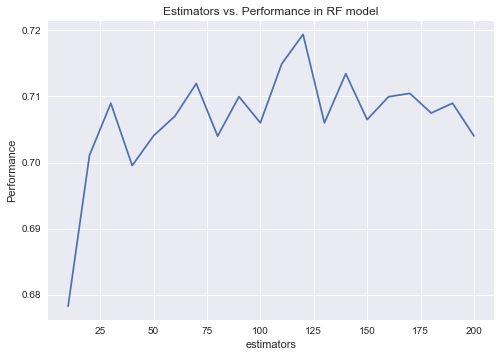

In [28]:
# Evaluate how performance changes with number of estimators

plt.plot(estimators,performance)
plt.xlabel('estimators')
plt.ylabel('Performance')
plt.title('Estimators vs. Performance in RF model')

## Conclusion

The decision tree cross validation model was able to run at at 1/10th the run time of the random forest cross validation model. The random forest model, however, was able to yield ~12% better accuracy. 

Ultimately in a real-world setting, deciding whether this gain in performance is worthwhile ultimately depends on the business problem you're dealing with, the amount of computational resources available and the volume of data you're dealing with. 

The difference between ~.04 and ~.43 seconds in this case is marginal, but as you deal with larger and larger data sets, the difference in run time is magnitudes greater. 

In the event that there is merit in running the random forest classification model but computational resources are limited, using methods such as recursive feature elimination can potentially enable users to achieve results superior to a decision tree model while minimizing the amount of additional computational resources needed. 

### Troubleshooting PCA -- getting it to work: 

The problem I had in my original attempt is that I failed to standardize the data prior to performing PCA. Because PCA maximizes on variance, so it's important that all attributes have the same relative variance.

The random forest model also apperas to have diminishing returns with each additional component used. 

In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

pca = PCA(n_components=7)

X = df.drop('target',axis=1)
X = StandardScaler().fit_transform(X)
X_pca = pca.fit_transform(X)

In [137]:
components_num = [1,2,3,4,5,6,7,8,9,10,11,12,13]
accuracy = []

Y = df['target']
rfc = ensemble.RandomForestClassifier(n_estimators=10)

for i in range(1,14):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X)
    rfc_score = cross_val_score(rfc, X_pca, Y, cv=10)
    accuracy.append(np.mean(rfc_score))

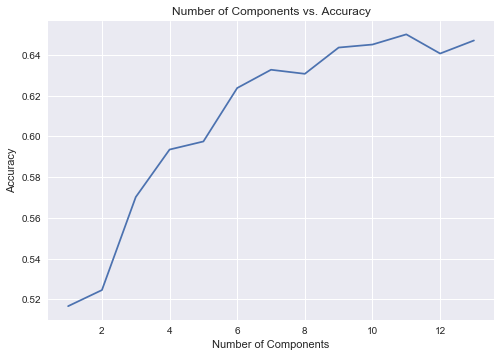

In [138]:
#Evaluate how run time changes with number of estimators

plt.plot(components_num,accuracy)
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Number of Components vs. Accuracy')